<a href="https://colab.research.google.com/github/deepjyotisaha85/eva4/blob/master/session11/S11_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
workingdir = '/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 11'
sys.path.append(workingdir)

In [3]:
%matplotlib inline
import torch
import torchvision
import numpy as np
from utils import datapreparation
from utils import display
from model import dnn
from model import resnet
from utils import training
from utils import evaluate
from utils import lrfinder
from utils import lr_rangetest
from utils import onecyclelr
from utils import gradcam 
from utils import gradvisualize 

  pip install torch-lr-finder -v --global-option="amp"


In [4]:
classes, trainloader, testloader = datapreparation.load(albumentations=True)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CUDA Available? True


shape: torch.Size([512, 3, 32, 32])


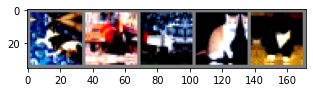

  cat truck truck   cat   cat


In [5]:
display.show_random_images(trainloader, classes, 5)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = resnet.CustomResNet11()
model = net.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
CustomResnetBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         294,912
        MaxPool2d-14            [-

/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 11/model/resnet.py:163: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 11/model/resnet.py:163: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)



Learning rate search finished. See the graph with {finder_name}.plot()


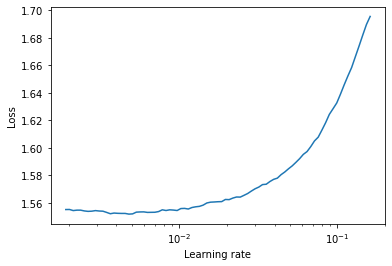

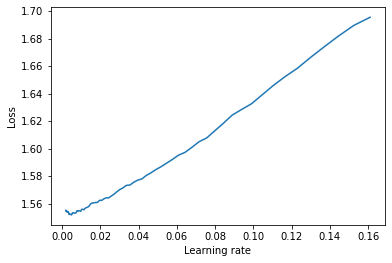

In [20]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
lr = lrfinder.LRFinder(model, optimizer, criterion, device="cuda")
lr.range_test(trainloader, end_lr=0.20, num_iter=len(trainloader), step_mode="exp")
lr.plot(log_lr=True)
lr.plot(log_lr=False)
lr.reset()

In [0]:
#import torch.nn as nn
#import torch.optim as optim
#from torch.optim.lr_scheduler import StepLR
#criterion = nn.CrossEntropyLoss()

#from torch.optim.lr_scheduler import ReduceLROnPlateau

In [18]:

initial_lr = 0.001
max_lr = 0.02
min_lr = max_lr * 0.1

EPOCHS = 24
steps_per_epoch = len(trainloader)
num_steps = steps_per_epoch * EPOCHS
peak_lr_epoch = 5 
pct_start = float (peak_lr_epoch/EPOCHS)
div_factor = float (max_lr/initial_lr)
final_div_factor = float (initial_lr/min_lr)

print("maxlr: ", max_lr)
print("min_lr: ", min_lr)
print("initial_lr: ", initial_lr)
print("epochs: ", EPOCHS)
print("steps_per_epoch: ", steps_per_epoch)
print("pct_start: ", pct_start)
print("div_factor: ", div_factor)
print("final_div_factor: ", final_div_factor)


optimizer = optim.SGD(model.parameters(), lr=max_lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr, 
                                                epochs=EPOCHS, 
                                                steps_per_epoch=steps_per_epoch, 
                                                pct_start=pct_start, 
                                                anneal_strategy='cos', 
                                                cycle_momentum=True, 
                                                base_momentum=0.85, 
                                                max_momentum=0.95, 
                                                div_factor=div_factor, 
                                                final_div_factor=final_div_factor, 
                                                last_epoch=-1)

maxlr:  0.02
min_lr:  0.002
initial_lr:  0.001
epochs:  24
steps_per_epoch:  98
pct_start:  0.20833333333333334
div_factor:  20.0
final_div_factor:  0.5


In [19]:

misclassified_imgs = []
correct_imgs = []
lrs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    print("Starting Learning Rate:", scheduler.get_lr())
    lrs = training.train_model(model, device, trainloader, optimizer, scheduler, criterion, epoch)
    misclassified_imgs, correct_imgs = training.test_model(model, device, criterion, testloader, epoch==EPOCHS-1)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1
Starting Learning Rate: [0.0010000000000000009]


/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 11/model/resnet.py:163: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)
Loss=2.1295268535614014 Batch_id=97 Accuracy=27.71: 100%|██████████| 98/98 [00:35<00:00,  2.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 3518/10000 (35.18%)

EPOCH: 2
Starting Learning Rate: [0.002821519753730628]


Loss=2.0664775371551514 Batch_id=97 Accuracy=38.12: 100%|██████████| 98/98 [00:35<00:00,  2.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 3735/10000 (37.35%)

EPOCH: 3
Starting Learning Rate: [0.007587566548979173]


Loss=1.9899190664291382 Batch_id=97 Accuracy=43.67: 100%|██████████| 98/98 [00:36<00:00,  2.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 4436/10000 (44.36%)

EPOCH: 4
Starting Learning Rate: [0.013470467041587778]


Loss=1.9650063514709473 Batch_id=97 Accuracy=48.09: 100%|██████████| 98/98 [00:36<00:00,  2.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 5014/10000 (50.14%)

EPOCH: 5
Starting Learning Rate: [0.018214259240710507]


Loss=1.7844308614730835 Batch_id=97 Accuracy=55.76: 100%|██████████| 98/98 [00:35<00:00,  2.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 6229/10000 (62.29%)

EPOCH: 6
Starting Learning Rate: [0.019999987189891662]


Loss=1.746922492980957 Batch_id=97 Accuracy=68.61: 100%|██████████| 98/98 [00:35<00:00,  2.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 6691/10000 (66.91%)

EPOCH: 7
Starting Learning Rate: [0.019874739739594097]


Loss=1.7451462745666504 Batch_id=97 Accuracy=73.45: 100%|██████████| 98/98 [00:35<00:00,  2.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 7303/10000 (73.03%)

EPOCH: 8
Starting Learning Rate: [0.019507412523920277]


Loss=1.694152593612671 Batch_id=97 Accuracy=76.43: 100%|██████████| 98/98 [00:35<00:00,  2.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 7721/10000 (77.21%)

EPOCH: 9
Starting Learning Rate: [0.018908025271763204]


Loss=1.6857579946517944 Batch_id=97 Accuracy=78.35: 100%|██████████| 98/98 [00:35<00:00,  2.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 7706/10000 (77.06%)

EPOCH: 10
Starting Learning Rate: [0.018092927704875764]


Loss=1.6608103513717651 Batch_id=97 Accuracy=80.01: 100%|██████████| 98/98 [00:35<00:00,  2.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 7758/10000 (77.58%)

EPOCH: 11
Starting Learning Rate: [0.017084353560081873]


Loss=1.6190500259399414 Batch_id=97 Accuracy=81.12: 100%|██████████| 98/98 [00:35<00:00,  2.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 7986/10000 (79.86%)

EPOCH: 12
Starting Learning Rate: [0.01590981411089494]


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8139/10000 (81.39%)

EPOCH: 13
Starting Learning Rate: [0.014601347731692948]


Loss=1.6174627542495728 Batch_id=97 Accuracy=83.86: 100%|██████████| 98/98 [00:36<00:00,  2.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8201/10000 (82.01%)

EPOCH: 14
Starting Learning Rate: [0.013194645974383247]


Loss=1.6019846200942993 Batch_id=97 Accuracy=84.90: 100%|██████████| 98/98 [00:35<00:00,  2.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8154/10000 (81.54%)

EPOCH: 15
Starting Learning Rate: [0.01172807999590745]


Loss=1.6016095876693726 Batch_id=97 Accuracy=85.40: 100%|██████████| 98/98 [00:35<00:00,  2.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8154/10000 (81.54%)

EPOCH: 16
Starting Learning Rate: [0.010241653893106193]


Loss=1.6095494031906128 Batch_id=97 Accuracy=86.17: 100%|██████████| 98/98 [00:35<00:00,  2.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8372/10000 (83.72%)

EPOCH: 17
Starting Learning Rate: [0.00877591349524024]


Loss=1.6217600107192993 Batch_id=97 Accuracy=86.75: 100%|██████████| 98/98 [00:35<00:00,  2.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8350/10000 (83.50%)

EPOCH: 18
Starting Learning Rate: [0.007370840379463319]


Loss=1.5949352979660034 Batch_id=97 Accuracy=87.32: 100%|██████████| 98/98 [00:36<00:00,  2.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8443/10000 (84.43%)

EPOCH: 19
Starting Learning Rate: [0.00606476127762158]


Loss=1.5823462009429932 Batch_id=97 Accuracy=88.48: 100%|██████████| 98/98 [00:35<00:00,  2.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8486/10000 (84.86%)

EPOCH: 20
Starting Learning Rate: [0.004893302622919158]


Loss=1.557457685470581 Batch_id=97 Accuracy=88.90: 100%|██████████| 98/98 [00:35<00:00,  2.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8542/10000 (85.42%)

EPOCH: 21
Starting Learning Rate: [0.003888418753691523]


Loss=1.5377954244613647 Batch_id=97 Accuracy=89.53: 100%|██████████| 98/98 [00:34<00:00,  2.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8720/10000 (87.20%)

EPOCH: 22
Starting Learning Rate: [0.0030775202823544734]


Loss=1.5688737630844116 Batch_id=97 Accuracy=89.85: 100%|██████████| 98/98 [00:34<00:00,  2.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8666/10000 (86.66%)

EPOCH: 23
Starting Learning Rate: [0.002482726405351528]


Loss=1.5541929006576538 Batch_id=97 Accuracy=90.54: 100%|██████████| 98/98 [00:35<00:00,  2.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8674/10000 (86.74%)

EPOCH: 24
Starting Learning Rate: [0.0021202615491354134]


Loss=1.5452669858932495 Batch_id=97 Accuracy=90.74: 100%|██████████| 98/98 [00:35<00:00,  2.74it/s]



Test set: Average loss: 0.0032, Accuracy: 8773/10000 (87.73%)



/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 11/model/resnet.py:163: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


GroundTruth:    car   cat plane  ship plane
Predicted:    car   cat plane  ship plane


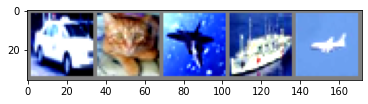

In [21]:
evaluate.show_predicted_actual(model, device, testloader, classes)

In [22]:
evaluate.evaluate_accuracy(model, device, testloader)

/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 11/model/resnet.py:163: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


Accuracy of the network on the 10000 test images: 87 %


In [23]:
evaluate.evaluate_classwise_accuracy(model, device, classes, testloader)

/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 11/model/resnet.py:163: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


Accuracy of plane : 100 %
Accuracy of   car : 91 %
Accuracy of  bird : 60 %
Accuracy of   cat : 100 %
Accuracy of  deer : 83 %
Accuracy of   dog : 100 %
Accuracy of  frog : 100 %
Accuracy of horse : 83 %
Accuracy of  ship : 81 %
Accuracy of truck : 100 %


Visualize GradCam

In [24]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = gradvisualize.VisualizeCam(model, classes, target_layers)
print (viz_cam)

In [25]:
#len(testloader.dataset)
print(misclassified_imgs[0]["img"])

tensor([[[-0.0049, -0.1795, -1.1161,  ..., -0.7510, -1.3701,  0.0904],
         [-0.0049, -0.1001, -1.0050,  ..., -0.7192, -1.1320,  0.0745],
         [-0.0366, -0.1001, -0.9574,  ..., -1.0526, -0.9097, -0.0366],
         ...,
         [-0.3541,  0.3920,  0.7412,  ..., -0.8145, -1.5923, -1.2272],
         [-0.9097, -0.2747,  0.8524,  ..., -0.9732, -1.4177, -1.2431],
         [-0.8621, -0.6716,  0.5349,  ..., -0.7827, -0.6557, -1.0367]],

        [[-0.2569, -0.3857, -1.1749,  ..., -0.9495, -1.4326, -0.1764],
         [-0.2569, -0.3213, -1.0783,  ..., -0.9333, -1.2555, -0.1603],
         [-0.2730, -0.3213, -1.0300,  ..., -1.1588, -1.0461, -0.2730],
         ...,
         [-0.4985,  0.1296,  0.4518,  ..., -0.9333, -1.5776, -1.2716],
         [-0.9333, -0.4019,  0.6128,  ..., -1.0622, -1.4326, -1.3038],
         [-0.8528, -0.6918,  0.3551,  ..., -0.9011, -0.7562, -1.1105]],

        [[-0.3728, -0.4627, -1.0174,  ..., -0.9125, -1.2723, -0.3128],
         [-0.3728, -0.4327, -0.9724,  ..., -0

/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 11/model/resnet.py:163: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


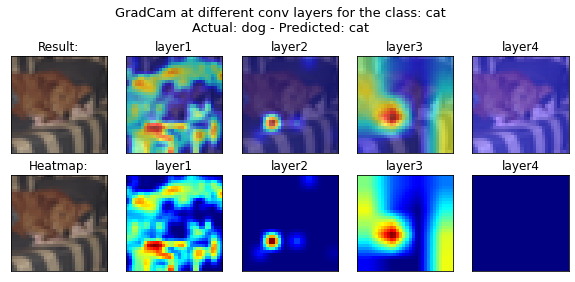

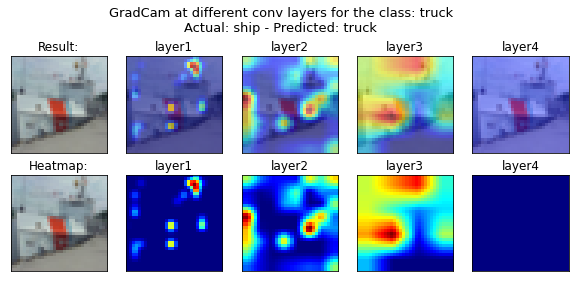

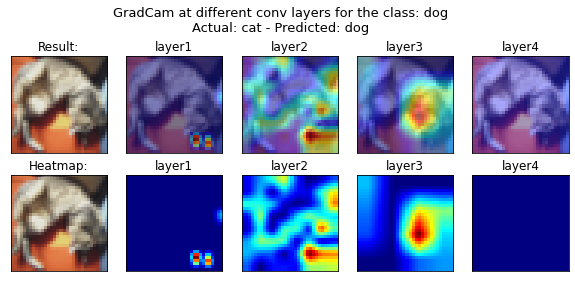

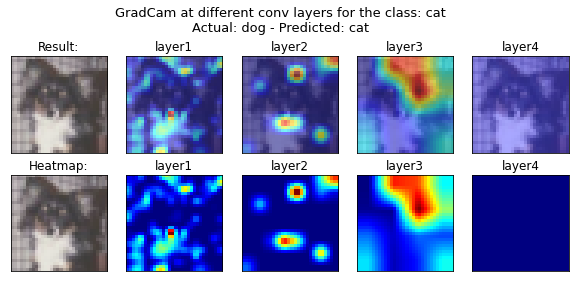

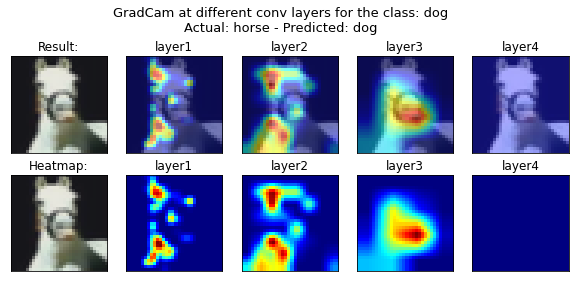

In [26]:
#GradCam for incorrectly classified images

num_img = 5
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
  #incorrect_pred_imgs
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect")

/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 11/model/resnet.py:163: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


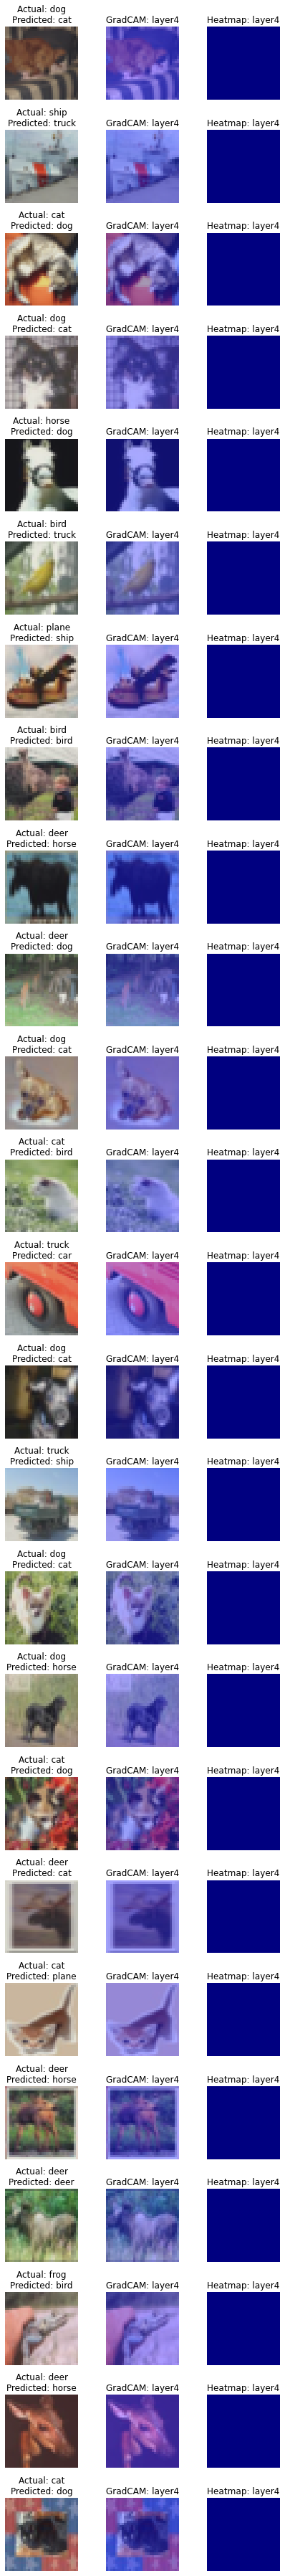

In [27]:
num_img = 25
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect", per_image=False)